In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
pd.options.display.max_rows = None
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from scipy import stats
import matplotlib.pyplot as plt

In [5]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
datas = [train_data, test_data]
for data in datas:
    data['relatives'] = data['SibSp'] + data['Parch']
    data['relatives_cat'] = data['relatives'] > 0
    data['relatives_cat'] = data['relatives_cat'].astype(int)
    data['Fare'] = data['Fare'].fillna(0)
    data['fare_pers'] = (data['Fare'] / (data['relatives'] + 1)).astype(int)

    data['Cabin'] = data['Cabin'].fillna('U0')
    data['cabin_letter'] = data['Cabin'].str[0]

    data['Age'] = data['Age'].fillna(data['Age'].median()).astype(int)
    data['Embarked'] = data['Embarked'].fillna('S')

    age_bins = [-0.01, 19, 26, 28, 36, 100]
    age_labels=['Age1', 'Age2', 'Age3', 'Age4', 'Age5']
    data['age_groups'] = pd.cut(data['Age'], age_bins, labels=age_labels)

    fare_bins = [-0.01, 6, 7, 10, 27, 1000]
    fare_labels=['Fare1', 'Fare2', 'Fare3', 'Fare4', 'Fare5']
    data['fare_groups'] = pd.cut(data['fare_pers'], fare_bins, labels=fare_labels)
    
    data['age_class']= data['Age']* data['Pclass']
    
    titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

    # extract titles
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    data['Title'] = data['Title'].map(titles)
    # filling NaN with 0, to get safe
    data['Title'] = data['Title'].fillna(0)

    
ages = train_data.groupby(train_data.age_groups).count()
print("Age groups:\n", ages)
fares = train_data.groupby(train_data.fare_groups).count()
print("\nFare groups:\n", fares)
# print(train_data[train_data['Age'] == 0])

print("Train Nan:\n", train_data.isna().sum())
print("Testn Nan:\n", test_data.isna().sum())

Age groups:
             PassengerId  Survived  Pclass  Name  Sex  Age  SibSp  Parch  \
age_groups                                                                
Age1                164       164     164   164  164  164    164    164   
Age2                155       155     155   155  155  155    155    155   
Age3                222       222     222   222  222  222    222    222   
Age4                156       156     156   156  156  156    156    156   
Age5                194       194     194   194  194  194    194    194   

            Ticket  Fare  Cabin  Embarked  relatives  relatives_cat  \
age_groups                                                            
Age1           164   164    164       164        164            164   
Age2           155   155    155       155        155            155   
Age3           222   222    222       222        222            222   
Age4           156   156    156       156        156            156   
Age5           194   194    194    

In [10]:
train_data[:20]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,relatives_cat,fare_pers,cabin_letter,age_groups,fare_groups,age_class,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,U0,S,1,1,3,U,Age2,Fare1,66,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,1,35,C,Age5,Fare5,38,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,U0,S,0,0,7,U,Age2,Fare2,78,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1,1,26,C,Age4,Fare4,35,3
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,U0,S,0,0,8,U,Age4,Fare3,105,1
5,6,0,3,"Moran, Mr. James",male,28,0,0,330877,8.4583,U0,Q,0,0,8,U,Age3,Fare3,84,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,0,0,51,E,Age5,Fare5,54,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,U0,S,4,1,4,U,Age1,Fare1,6,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,U0,S,2,1,3,U,Age3,Fare1,81,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,U0,C,1,1,15,U,Age1,Fare4,28,3


In [11]:
# train_data["cabin_letter"].unique()

In [12]:
for data in datas:
    cleanup_nums = {"Sex":     {"male": 1, "female": 0},
                    "Embarked": {"C": 0, "Q": 1, "S": 2},
                    "cabin_letter": {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8, "U": 9},
                    "age_groups": {"Age1": 1, "Age2": 2, "Age3": 3, "Age4": 4, "Age5": 5},
                    "fare_groups": {"Fare1": 1, "Fare2": 2, "Fare3": 3, "Fare4": 4, "Fare5": 5}
                   }
    data.replace(cleanup_nums, inplace=True)

In [13]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,relatives_cat,fare_pers,cabin_letter,age_groups,fare_groups,age_class,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,U0,2,1,1,3,9,2,1,66,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,0,1,1,35,3,5,5,38,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,U0,2,0,0,7,9,2,2,78,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,2,1,1,26,3,4,4,35,3
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,U0,2,0,0,8,9,4,3,105,1


In [14]:
train_data.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,relatives_cat,fare_pers,cabin_letter,age_groups,fare_groups,age_class,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.345679,0.523008,0.381594,32.204208,1.536476,0.904602,0.397306,19.450056,7.716049,3.068462,2.942761,64.049383,1.728395
std,257.353842,0.486592,0.836071,0.477990,13.028212,1.102743,0.806057,49.693429,0.791503,1.613459,0.489615,35.842046,2.460739,1.397761,1.381288,32.490480,1.030039
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,0.000000,7.000000,9.000000,2.000000,2.000000,40.000000,1.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,2.000000,0.000000,0.000000,8.000000,9.000000,3.000000,3.000000,63.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,1.000000,23.000000,9.000000,4.000000,4.000000,84.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,10.000000,1.000000,512.000000,9.000000,5.000000,5.000000,222.000000,5.000000


In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    int64  
 5   Age            891 non-null    int64  
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          891 non-null    object 
 11  Embarked       891 non-null    int64  
 12  relatives      891 non-null    int64  
 13  relatives_cat  891 non-null    int64  
 14  fare_pers      891 non-null    int64  
 15  cabin_letter   891 non-null    int64  
 16  age_groups     891 non-null    int64  
 17  fare_groups    891 non-null    int64  
 18  age_class 

In [16]:
irrelevant_columns_train = ['Ticket', 'Name', 'Fare', 'Cabin', 'PassengerId', 'Parch', 'relatives_cat']
train_data_prep = train_data.drop(irrelevant_columns_train, axis=1)

irrelevant_columns_test = ['Ticket', 'Name', 'Fare', 'Cabin', 'Parch', 'relatives_cat']
test_data_prep = test_data.drop(irrelevant_columns_train, axis=1)

In [17]:
train_data_prep.head()

,Survived,Pclass,Sex,Age,SibSp,Embarked,relatives,fare_pers,cabin_letter,age_groups,fare_groups,age_class,Title
0,0,3,1,22,1,2,1,3,9,2,1,66,1
1,1,1,0,38,1,0,1,35,3,5,5,38,3
2,1,3,0,26,0,2,0,7,9,2,2,78,2
3,1,1,0,35,1,2,1,26,3,4,4,35,3
4,0,3,1,35,0,2,0,8,9,4,3,105,1


In [18]:
train_data_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Survived      891 non-null    int64
 1   Pclass        891 non-null    int64
 2   Sex           891 non-null    int64
 3   Age           891 non-null    int64
 4   SibSp         891 non-null    int64
 5   Embarked      891 non-null    int64
 6   relatives     891 non-null    int64
 7   fare_pers     891 non-null    int64
 8   cabin_letter  891 non-null    int64
 9   age_groups    891 non-null    int64
 10  fare_groups   891 non-null    int64
 11  age_class     891 non-null    int64
 12  Title         891 non-null    int64
dtypes: int64(13)
memory usage: 90.6 KB


In [19]:
print(train_data_prep[0:0])

Empty DataFrame
Columns: [Survived, Pclass, Sex, Age, SibSp, Embarked, relatives, fare_pers, cabin_letter, age_groups, fare_groups, age_class, Title]
Index: []


In [20]:
test_data_prep.head()

,Pclass,Sex,Age,SibSp,Embarked,relatives,fare_pers,cabin_letter,age_groups,fare_groups,age_class,Title
0,3,1,34,0,1,0,7,9,4,2,102,1
1,3,0,47,1,2,1,3,9,5,1,141,3
2,2,1,62,0,1,0,9,9,5,3,124,1
3,3,1,27,0,2,0,8,9,3,3,81,1
4,3,0,22,1,2,2,4,9,2,1,66,3


In [21]:
test_data_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Pclass        418 non-null    int64
 1   Sex           418 non-null    int64
 2   Age           418 non-null    int64
 3   SibSp         418 non-null    int64
 4   Embarked      418 non-null    int64
 5   relatives     418 non-null    int64
 6   fare_pers     418 non-null    int64
 7   cabin_letter  418 non-null    int64
 8   age_groups    418 non-null    int64
 9   fare_groups   418 non-null    int64
 10  age_class     418 non-null    int64
 11  Title         418 non-null    int64
dtypes: int64(12)
memory usage: 39.3 KB


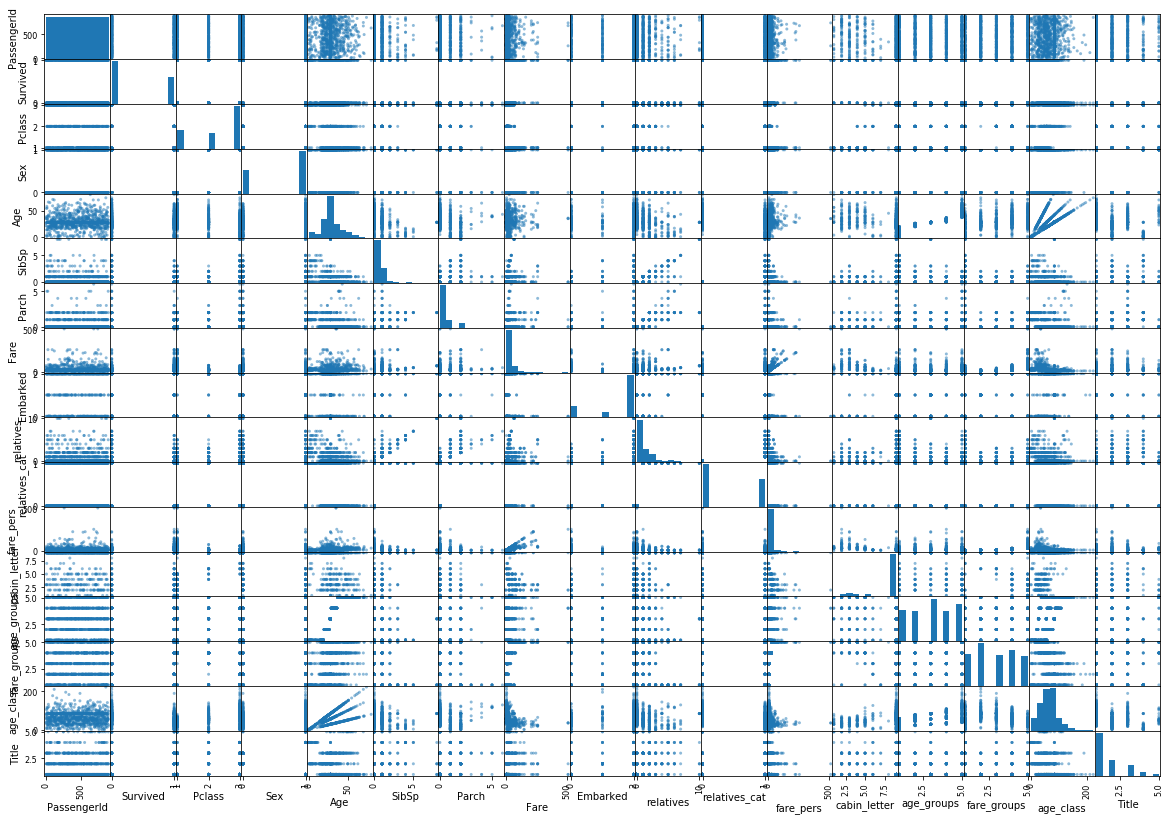

In [22]:
from pandas.plotting import scatter_matrix
scatter_matrix(train_data, figsize=(20, 14))
plt.show()

In [23]:
corr_matrix = train_data.corr()
print("Correlation matrix:\n", corr_matrix["Survived"].sort_values(ascending=False))

Correlation matrix:
 Survived         1.000000
Title            0.407753
fare_groups      0.260077
Fare             0.257307
fare_pers        0.221239
relatives_cat    0.203367
Parch            0.081629
relatives        0.016639
PassengerId     -0.005007
age_groups      -0.030420
SibSp           -0.035322
Age             -0.064909
Embarked        -0.167675
cabin_letter    -0.301116
age_class       -0.324499
Pclass          -0.338481
Sex             -0.543351
Name: Survived, dtype: float64


In [24]:
survived_ticket_class = train_data.groupby(['Pclass', 'Survived']).size()
print("How many passengers died or survived in each ticket class:\n", survived_ticket_class)

# survived_ticket_class_perc = pd.DataFrame({'Percentage': train_data.groupby(['Pclass', 'Survived']).size() / len(train_data['Pclass']) * 100})

How many passengers died or survived in each ticket class:
 Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
dtype: int64


In [25]:
survived_sex = train_data.groupby(['Sex', 'Survived']).size()
print("How many male and female passengers died or survived:\n", survived_sex)

How many male and female passengers died or survived:
 Sex  Survived
0    0            81
     1           233
1    0           468
     1           109
dtype: int64


In [26]:
survived_embarked = train_data.groupby(['Embarked', 'Survived']).size()
print("How many passengers died or survived depending on where they embarked:\n", survived_embarked)

How many passengers died or survived depending on where they embarked:
 Embarked  Survived
0         0            75
          1            93
1         0            47
          1            30
2         0           427
          1           219
dtype: int64


In [27]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 100]

groups = train_data.groupby(['Survived', pd.cut(train_data.Age, bins)])
print("How many passengers died or survived depending of age:\n", groups.size().unstack())

How many passengers died or survived depending of age:
 Age       (0, 10]  (10, 20]  (20, 30]  (30, 40]  (40, 50]  (50, 60]  (60, 70]  \
Survived                                                                        
0              26        72       272        86        51        25        14   
1              31        44       136        69        33        17         4   

Age       (70, 100]  
Survived             
0                 3  
1                 1  


In [28]:
bins = [0, 5, 10, 30, 600]

groups = train_data.groupby(['Survived', pd.cut(train_data.fare_pers, bins)])
print("How many passengers died or survived in each ticket price:\n", groups.size().unstack())

How many passengers died or survived in each ticket price:
 fare_pers  (0, 5]  (5, 10]  (10, 30]  (30, 600]
Survived                                       
0              69      312       110         44
1              35      115       108         83


In [29]:
survived_with_relatives = train_data.groupby(['relatives_cat', 'Survived']).size()
print("How many passengers with relatives died or survived :\n", survived_with_relatives)

How many passengers with relatives died or survived :
 relatives_cat  Survived
0              0           374
               1           163
1              0           175
               1           179
dtype: int64


Machine Learning Modell

--- Splitting data ---

In [30]:
predict = 'Survived'

X = train_data_prep.drop([predict], axis=1)
y = train_data_prep[predict]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

--- Scaling and transforming data ---

In [31]:
numerical_X = X_train.drop(['Pclass', 'Sex', 'Embarked', 'cabin_letter', 'age_groups', 'fare_groups'], axis=1)
num_attr = list(numerical_X)
cat_attr = ['Pclass', 'Sex', 'Embarked', 'cabin_letter', 'age_groups', 'fare_groups']

Preprocessing with Standard Scaler

In [32]:
scale_transform = ColumnTransformer([
                            ('scaler', StandardScaler(), num_attr),
                            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attr)
                        ])

X_train_scaled = scale_transform.fit_transform(X_train)
X_test_scaled = scale_transform.transform(X_test)

Preprocessing with MinMax Scaler

In [33]:
scale_transform_minmax = ColumnTransformer([
                            ('scaler', MinMaxScaler(), num_attr),
                            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attr)
                        ])

X_train_scaled_minmax = scale_transform_minmax.fit_transform(X_train)
X_test_scaled_minmax = scale_transform_minmax.transform(X_test)

--- Fast check of some classification algorithms ---

Logistic Regression

In [34]:
# log_reg = LogisticRegression()
# log_reg.fit(X_train_scaled, y_train)
# print("Log Reg test set score of:\n", (log_reg.score(X_test_scaled, y_test))) #0,80

KNN

In [35]:
# knn = KNeighborsClassifier(n_neighbors=7)
# knn.fit(X_train_scaled, y_train)
# print("Test set score of 7-nn:\n", (knn.score(X_test_scaled, y_test))) #0,81

SVC

In [36]:
# svm = SVC(C=1)
# svm.fit(X_train_scaled, y_train)
# print("SVM test accuracy C=1:\n", svm.score(X_test_scaled, y_test)) #0,81

Random Forest

In [37]:
# forest = RandomForestClassifier(random_state=42)
# forest.fit(X_train_scaled, y_train)
# print("Random Forest test accuracy:\n", forest.score(X_test_scaled, y_test)) #0,80

Applying unsupervised Machine Learning.

--- PCA ---

In [38]:
# pca = PCA(n_components=7, random_state=42)
# pca.fit(X_train_scaled)

# X_train_pca = pca.transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

In [39]:
# irrelevant_columns_train_1 = ['Survived']
# train_data_prep_1 = train_data.drop(irrelevant_columns_train_1, axis=1)
# names = list(train_data_prep_1)

# plt.matshow(pca.components_, cmap='viridis')
# plt.yticks([0, 1], ["First component", "Second component"])
# plt.colorbar()
# plt.xticks(range(len(names)), names, rotation=60, ha='left')
# plt.xlabel("Feature")
# plt.ylabel("Principal components")

In [40]:
# clf = Pipeline([
#         ("kpca", KernelPCA(n_components=7)),
#         ("log_reg", LogisticRegression())
#     ])
# param_grid = [{
#         "kpca__gamma": np.linspace(0.03, 0.05, 10),
#         "kpca__kernel": ["rbf", "sigmoid"]
#     }]
# grid_search = GridSearchCV(clf, param_grid, cv=3)
# grid_search.fit(X_train_scaled, y_train)
# print("Best params kPCA with LogReg", grid_search.best_params_)

# rbf_pca = KernelPCA(n_components = 7, kernel="rbf", gamma=0.038)
# X_train_red = rbf_pca.fit_transform(X_train_scaled)
# X_test_red = rbf_pca.fit_transform(X_test_scaled)

# log_reg_kpca = LogisticRegression()
# log_reg_kpca.fit(X_train_red, y_train)
# print("Log Reg after kPCA test set score of:\n", (log_reg_kpca.score(X_test_red, y_test))) #0,82

In [41]:
# log_reg_pca = LogisticRegression()
# log_reg_pca.fit(X_train_pca, y_train)
# print("Log Reg after PCA test set score of:\n", (log_reg_pca.score(X_test_pca, y_test))) #0,79

In [42]:
# svm_pca = SVC(C=1)
# svm_pca.fit(X_train_pca, y_train)
# print("SVM after PCA test accuracy C=200:\n", svm_pca.score(X_test_pca, y_test)) #0,81

In [43]:
# knn_pca = KNeighborsClassifier(n_neighbors=3)
# knn_pca.fit(X_train_pca, y_train)
# print("KNN with PCA test set score of 3-nn:\n", (knn_pca.score(X_test_pca, y_test))) #0,826

# pipe_knn = Pipeline([('classifier', KNeighborsClassifier())])
# param_grid_knn = [
#     {'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}
#     ]
# grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=10)
# grid_knn.fit(X_train_pca, y_train)

# # y_pred_knn = grid_knn.predict(X_test_scaled)
# # print("Classification report KNN:\n", classification_report(y_test, y_pred_knn))
# print("KNN pca - Best params:\n", grid_knn.best_params_)
# print("KNN pca - Best cross-validation score:\n", grid_knn.best_score_)
# print("KNN pca - Accuracy score:\n", grid_knn.score(X_test_pca, y_test))

Grid search for the best machine learning model

18.05.2020
1 try

Log Reg - Best params:
 {'classifier__C': 100}
Log Reg - Best cross-validation score:
 0.8090179968701096
Log Reg - Accuracy score:
 0.8044692737430168
SVC - Best params:
 {'classifier__C': 1, 'classifier__gamma': 0.1}
SVC - Best cross-validation score:
 0.8286189358372458
SVC - Accuracy score:
 0.8100558659217877
KNN - Best params:
 {'classifier__n_neighbors': 11}
KNN - Best cross-validation score:
 0.7992175273865414
KNN - Accuracy score:
 0.8212290502793296
R Forest - Best params:
 {'classifier__max_depth': 6, 'classifier__max_features': 7, 'classifier__n_estimators': 300}
R Forest - Best cross-validation score:
 0.8286580594679187
R Forest - Accuracy score:
 0.8212290502793296

In [44]:
# pipe_logreg = Pipeline([('preprocessing', scale_transform_minmax), ('classifier', LogisticRegression(max_iter=100000, random_state=42))])
# param_grid_logreg = [
#     {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500, 1000, 10000]},
#     ]
# grid_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, cv=10)
# grid_logreg.fit(X_train, y_train)

# # y_pred_logreg = grid_logreg.predict(X_test_scaled_minmax)
# # print("Classification report Log Reg:\n", classification_report(y_test, y_pred_logreg))
# print("Log Reg - Best params:\n", grid_logreg.best_params_)
# print("Log Reg - Best cross-validation score:\n", grid_logreg.best_score_)
# print("Log Reg - Accuracy score:\n", grid_logreg.score(X_test, y_test))

In [45]:
# degrees = range(1, 3)

# for degr in degrees:
#     degr = degr + 1
#     poly_features = PolynomialFeatures(degree=degr, include_bias=False)
#     print("Polynomial Features degree:", degr)
#     print(poly_features.get_feature_names)
#     X_train_poly = poly_features.fit_transform(X_train_scaled)
#     X_test_poly = poly_features.transform(X_test_scaled)

#     pipe_logreg_poly = Pipeline([('classifier', LogisticRegression(max_iter=100000, random_state=42))])
#     param_grid_logreg_poly = [
#             {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500, 1000, 10000]},
#         ]
#     grid_logreg_poly = GridSearchCV(pipe_logreg_poly, param_grid_logreg_poly, cv=10)
#     grid_logreg_poly.fit(X_train_poly, y_train)

#     # y_pred_logreg = grid_logreg.predict(X_test_scaled_minmax)
#     # print("Classification report Log Reg:\n", classification_report(y_test, y_pred_logreg))
#     print("Log Reg Poly - Best params:\n", grid_logreg_poly.best_params_)
#     print("Log Reg Poly - Best cross-validation score:\n", grid_logreg_poly.best_score_)
#     print("Log Reg Poly - Accuracy score:\n", grid_logreg_poly.score(X_test_poly, y_test), "\n---")

In [46]:
# pipe_svc = Pipeline([('preprocessing', scale_transform), ('classifier', SVC(random_state=42))])
# param_grid_svc = [
#     {'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
#      'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}, 
#     ]
# grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=10)
# grid_svc.fit(X_train, y_train)

# # y_pred_svc = grid_svc.predict(X_test_scaled)
# # print("Classification report SVC:\n", classification_report(y_test, y_pred_svc))
# print("SVC - Best params:\n", grid_svc.best_params_)
# print("SVC - Best cross-validation score:\n", grid_svc.best_score_)
# print("SVC - Accuracy score:\n", grid_svc.score(X_test, y_test))

In [47]:
pipe_knn = Pipeline([('preprocessing', scale_transform_minmax), ('classifier', KNeighborsClassifier())])
param_grid_knn = [
    {'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}
    ]
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=10)
grid_knn.fit(X_train, y_train)

# y_pred_knn = grid_knn.predict(X_test_scaled)
# print("Classification report KNN:\n", classification_report(y_test, y_pred_knn))
print("KNN - Best params:\n", grid_knn.best_params_)
print("KNN - Best cross-validation score:\n", grid_knn.best_score_)
print("KNN - Accuracy score:\n", grid_knn.score(X_test, y_test))

KNN - Best params:
 {'classifier__n_neighbors': 13}
KNN - Best cross-validation score:
 0.8216940532081377
KNN - Accuracy score:
 0.8268156424581006


KNN - Best params:
 {'classifier__n_neighbors': 7}
KNN - Best cross-validation score:
 0.8160211267605634
KNN - Accuracy score:
 0.8491620111731844

In [48]:
# n_comps = range(2, 8)
# for n_comp in n_comps:
#     n_comp = n_comp + 1
#     print("PCA for n_components:", n_comp)
#     pca = PCA(n_components=n_comp, random_state=42)
#     pca.fit(X_train_scaled)
    
#     X_train_pca = pca.transform(X_train_scaled)
#     X_test_pca = pca.transform(X_test_scaled)

#     pipe_knn_pca = Pipeline([('classifier', KNeighborsClassifier())])
#     param_grid_knn_pca = [
#         {'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}
#         ]
#     grid_knn_pca = GridSearchCV(pipe_knn_pca, param_grid_knn_pca, cv=10)
#     grid_knn_pca.fit(X_train_pca, y_train)

#     # y_pred_knn = grid_knn.predict(X_test_scaled)
#     # print("Classification report KNN:\n", classification_report(y_test, y_pred_knn))
#     print("KNN PCA - Best params:\n", grid_knn_pca.best_params_)
#     print("KNN PCA - Best cross-validation score:\n", grid_knn_pca.best_score_)
#     print("KNN PCA - Accuracy score:\n", grid_knn_pca.score(X_test_pca, y_test), "\n---")

In [49]:
# pipe_forest = Pipeline([('classifier', RandomForestClassifier(random_state=42))])
# param_grid_forest = [
#     {'classifier__max_depth': [3, 4, 5, 6, 7],
#      'classifier__n_estimators': [10, 50, 100, 200, 300],
#      'classifier__max_features': [1, 2, 3, 4, 5, 6, 7, 8]}
#     ]
# grid_forest = GridSearchCV(pipe_forest, param_grid_forest, cv=10)
# grid_forest.fit(X_train, y_train)

# # y_pred_forest = grid_forest.predict(X_test_scaled)
# # print("Classification report Random Forest:\n", classification_report(y_test, y_pred_forest))
# print("R Forest - Best params:\n", grid_forest.best_params_)
# print("R Forest - Best cross-validation score:\n", grid_forest.best_score_)
# print("R Forest - Accuracy score:\n", grid_forest.score(X_test, y_test))

GridsearchCV:
R Forest - Best params:
 {'classifier__max_depth': 6, 'classifier__max_features': 5, 'classifier__n_estimators': 100}
R Forest - Best cross-validation score:
 0.8356611893583725
R Forest - Accuracy score:
 0.8100558659217877

THE BEST MODELS:
* -knn
* -random forest

In [50]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=6, max_features=5)
random_forest.fit(X_train, y_train)

prediction_rf = random_forest.predict(X_test)

random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print('Accuracy rf train:', acc_random_forest)

acc_random_forest_test = round(random_forest.score(X_test, y_test) * 100, 2)
print('Accuracy rf test:', acc_random_forest_test)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

Accuracy rf train: 89.89
Accuracy rf test: 84.92


,importance
feature,
Title,0.276
Sex,0.192
age_class,0.091
Pclass,0.082
fare_pers,0.081
Age,0.063
relatives,0.059
cabin_letter,0.055
fare_groups,0.036


In [51]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_scaled, y_train)
prediction_knn = knn.predict(X_test_scaled)
print("Test set score of 13-nn:\n", (knn.score(X_test_scaled, y_test)))

Test set score of 13-nn:
 0.8212290502793296


random forest confusion matrix

In [52]:
predictions_rf = cross_val_predict(random_forest, X_train, y_train, cv=10)
confusion_matrix(y_train, predictions_rf)

array([[405,  39],
       [ 80, 188]])

In [53]:
predictions_rf_test = cross_val_predict(random_forest, X_test, y_test, cv=10)
confusion_matrix(y_test, predictions_rf_test)

array([[92, 13],
       [13, 61]])

knn confusion matrix

In [54]:
predictions_knn = cross_val_predict(knn, X_train, y_train, cv=10)
confusion_matrix(y_train, predictions_knn)

array([[369,  75],
       [128, 140]])

In [55]:
predictions_knn_test = cross_val_predict(knn, X_test, y_test, cv=10)
confusion_matrix(y_test, predictions_knn_test)

array([[87, 18],
       [30, 44]])

In [56]:
class_report_rf = classification_report(y_test, prediction_rf)
print("Classification report RF:\n", class_report_rf)

Classification report RF:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       105
           1       0.85      0.77      0.81        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



In [57]:
class_report_knn = classification_report(y_test, prediction_knn)
print("Classification report KNN:\n", class_report_knn)

Classification report KNN:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



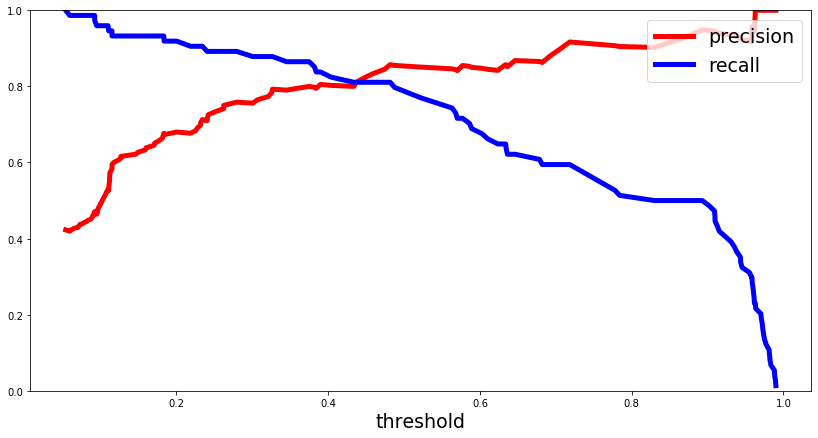

In [58]:
y_scores = random_forest.predict_proba(X_test)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(
    y_test, y_scores)

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

In [59]:
r_a_score = roc_auc_score(y_test, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.8999356499356499


In [60]:
prediction_rf_test = random_forest.predict(test_data_prep)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': prediction_rf_test})
print(output[:20])
output.to_csv('bartas_submission.csv', index=False)
print("Your submission was successfully saved!")

    PassengerId  Survived
0           892         0
1           893         0
2           894         0
3           895         0
4           896         0
5           897         0
6           898         1
7           899         0
8           900         1
9           901         0
10          902         0
11          903         0
12          904         1
13          905         0
14          906         1
15          907         1
16          908         0
17          909         0
18          910         1
19          911         0
Your submission was successfully saved!
